## Introducción

El set de datos utilziado es real. Consiste en un conjunto de datos del repositorio de machine Learning de la UCI ('Communities and Crime Data Set') https://archive.ics.uci.edu/ml/datasets/communities+and+crime. 
El set contiene datos reales socioeconómicos del Censo de EE.UU. de 1990, datos de aplicación de la ley de la encuesta LEMAS de EE.UU. de 1990 y datos de delincuencia del UCR del FBI de 1995. El set de datos contiene un total de 147 atributos y 2216 instancias.

## Objetivos

- Exportar el set de datos
- Limpieza de Datos Nulos
- Analisis de Variables
- Seleccion de Mejores variables predictoras (Correlacion, PCA, RFECV)
- Pronostico de la Variable 'Violent Crimes per Pod' (Regresion Lineal, Ridge, Lasso, Elastic net)

In [1]:
# Librerias Importadas
import requests
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
base = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data', header = None)
names = 'https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names'

In [3]:
aux = requests.get(names)
header = re.findall(r'\@attribute (\w*)', aux.text)
del aux

In [4]:
base.columns = header

In [5]:
base.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [6]:
base.shape

(1994, 128)

## Tratamiento de datos perdidos
Se eliminaran todas las variables que presenten datos perdidos

In [7]:
base = base.replace(['?'], np.nan)
base.isnull().sum()

state                     0
county                 1174
community              1177
communityname             0
fold                      0
                       ... 
LemasPctPolicOnPatr    1675
LemasGangUnitDeploy    1675
LemasPctOfficDrugUn       0
PolicBudgPerPop        1675
ViolentCrimesPerPop       0
Length: 128, dtype: int64

<AxesSubplot:>

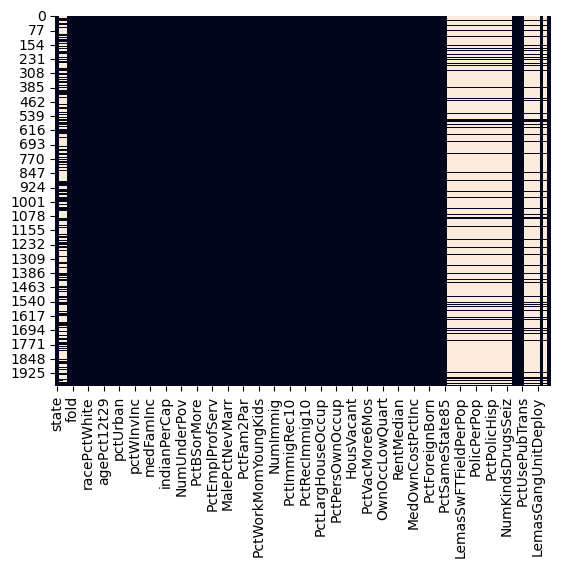

In [8]:
sns.heatmap(base.isnull(), cbar=False)

In [9]:
# se reducen de 128 a 103 variables
base = base.dropna(axis=1)
base.shape

(1994, 103)

<AxesSubplot:>

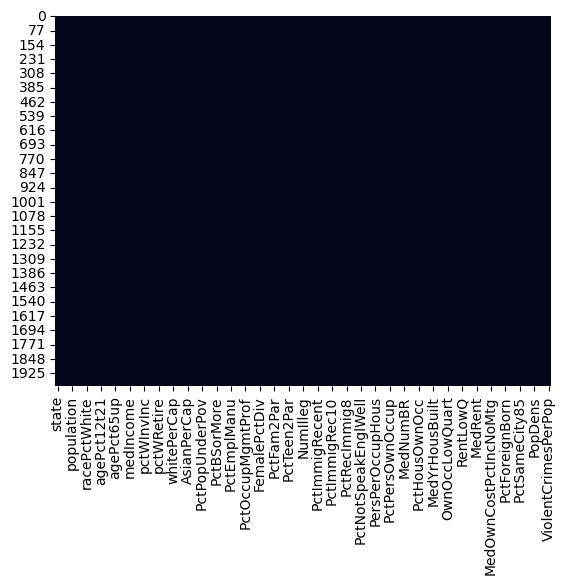

In [10]:
sns.heatmap(base.isnull(), cbar=False)

In [11]:
# No existe ninguna variable con valores nulos
base.isnull().sum().sum()

0

## Analisis de Variables

In [12]:
base.head()

,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,8,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,53,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,24,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,34,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [13]:
# Verificamos los tipos de datos de las variables
# Se puede observar que 100 variables ya se encuentran reescaladas entre 0 y 1
# Quedan 3 variables que son cualitativas nominales (communnity name, state, fold)
base.dtypes.value_counts()

float64    100
int64        2
object       1
dtype: int64

In [14]:
# la variables community name se eliminara dado que mas del 80 % no tiene manera de correlacionarse con otros datos
# Ademas de que la base de UCI la considera como variable no predictiva solo para informacion
base['communityname'].value_counts()

Greenvillecity      5
Jacksonvillecity    5
Auburncity          5
Athenscity          4
Springfieldcity     4
                   ..
RedondoBeachcity    1
GrantsPasscity      1
FortWorthcity       1
Raleighcity         1
Ontariocity         1
Name: communityname, Length: 1828, dtype: int64

In [15]:
base = base.drop(['communityname'], axis=1)

In [16]:
# La variable fold fue generada aleatoriamente para realizar cross validation
# Sin embargo para el desarrollo del modelo se utilizara CV desde los propios algoritmos
# Por lo que se eliminara
base['fold'].value_counts()

1     200
2     200
3     200
4     200
5     199
6     199
7     199
8     199
9     199
10    199
Name: fold, dtype: int64

In [17]:
base = base.drop(['fold'], axis=1)

In [18]:
# En primera instancia la variable state se convirtio en dummies llegando a un total de 146 variables
# Sin embargo al utilizar RFECV para seleccionar los mejores predictores, el algoritmo retornaba unicamente dummies
# Por lo que se decidio eliminar esas variables
# adjunto el codigo usado inicialmente

# base["state"] = base["state"].astype('object')
# base['state'].value_counts()

# features = ['state']

# dummies = pd.get_dummies(base[features])
# base = pd.concat([base.drop(features, axis=1), dummies], axis=1)

In [19]:
base = base.drop(['state'], axis=1)

In [20]:
# Finalmente nos quedamos con 100 variables, 99 independientes y 1 dependiente
base.dtypes.value_counts()

float64    100
dtype: int64

In [21]:
base.describe().T

,count,mean,std,min,25%,50%,75%,max
population,1994.0,0.057593,0.126906,0.0,0.01,0.02,0.05,1.0
householdsize,1994.0,0.463395,0.163717,0.0,0.35,0.44,0.54,1.0
racepctblack,1994.0,0.179629,0.253442,0.0,0.02,0.06,0.23,1.0
racePctWhite,1994.0,0.753716,0.244039,0.0,0.63,0.85,0.94,1.0
racePctAsian,1994.0,0.153681,0.208877,0.0,0.04,0.07,0.17,1.0
...,...,...,...,...,...,...,...,...
LandArea,1994.0,0.065231,0.109459,0.0,0.02,0.04,0.07,1.0
PopDens,1994.0,0.232854,0.203092,0.0,0.10,0.17,0.28,1.0
PctUsePubTrans,1994.0,0.161685,0.229055,0.0,0.02,0.07,0.19,1.0
LemasPctOfficDrugUn,1994.0,0.094052,0.240328,0.0,0.00,0.00,0.00,1.0


## Correlacion de Variables

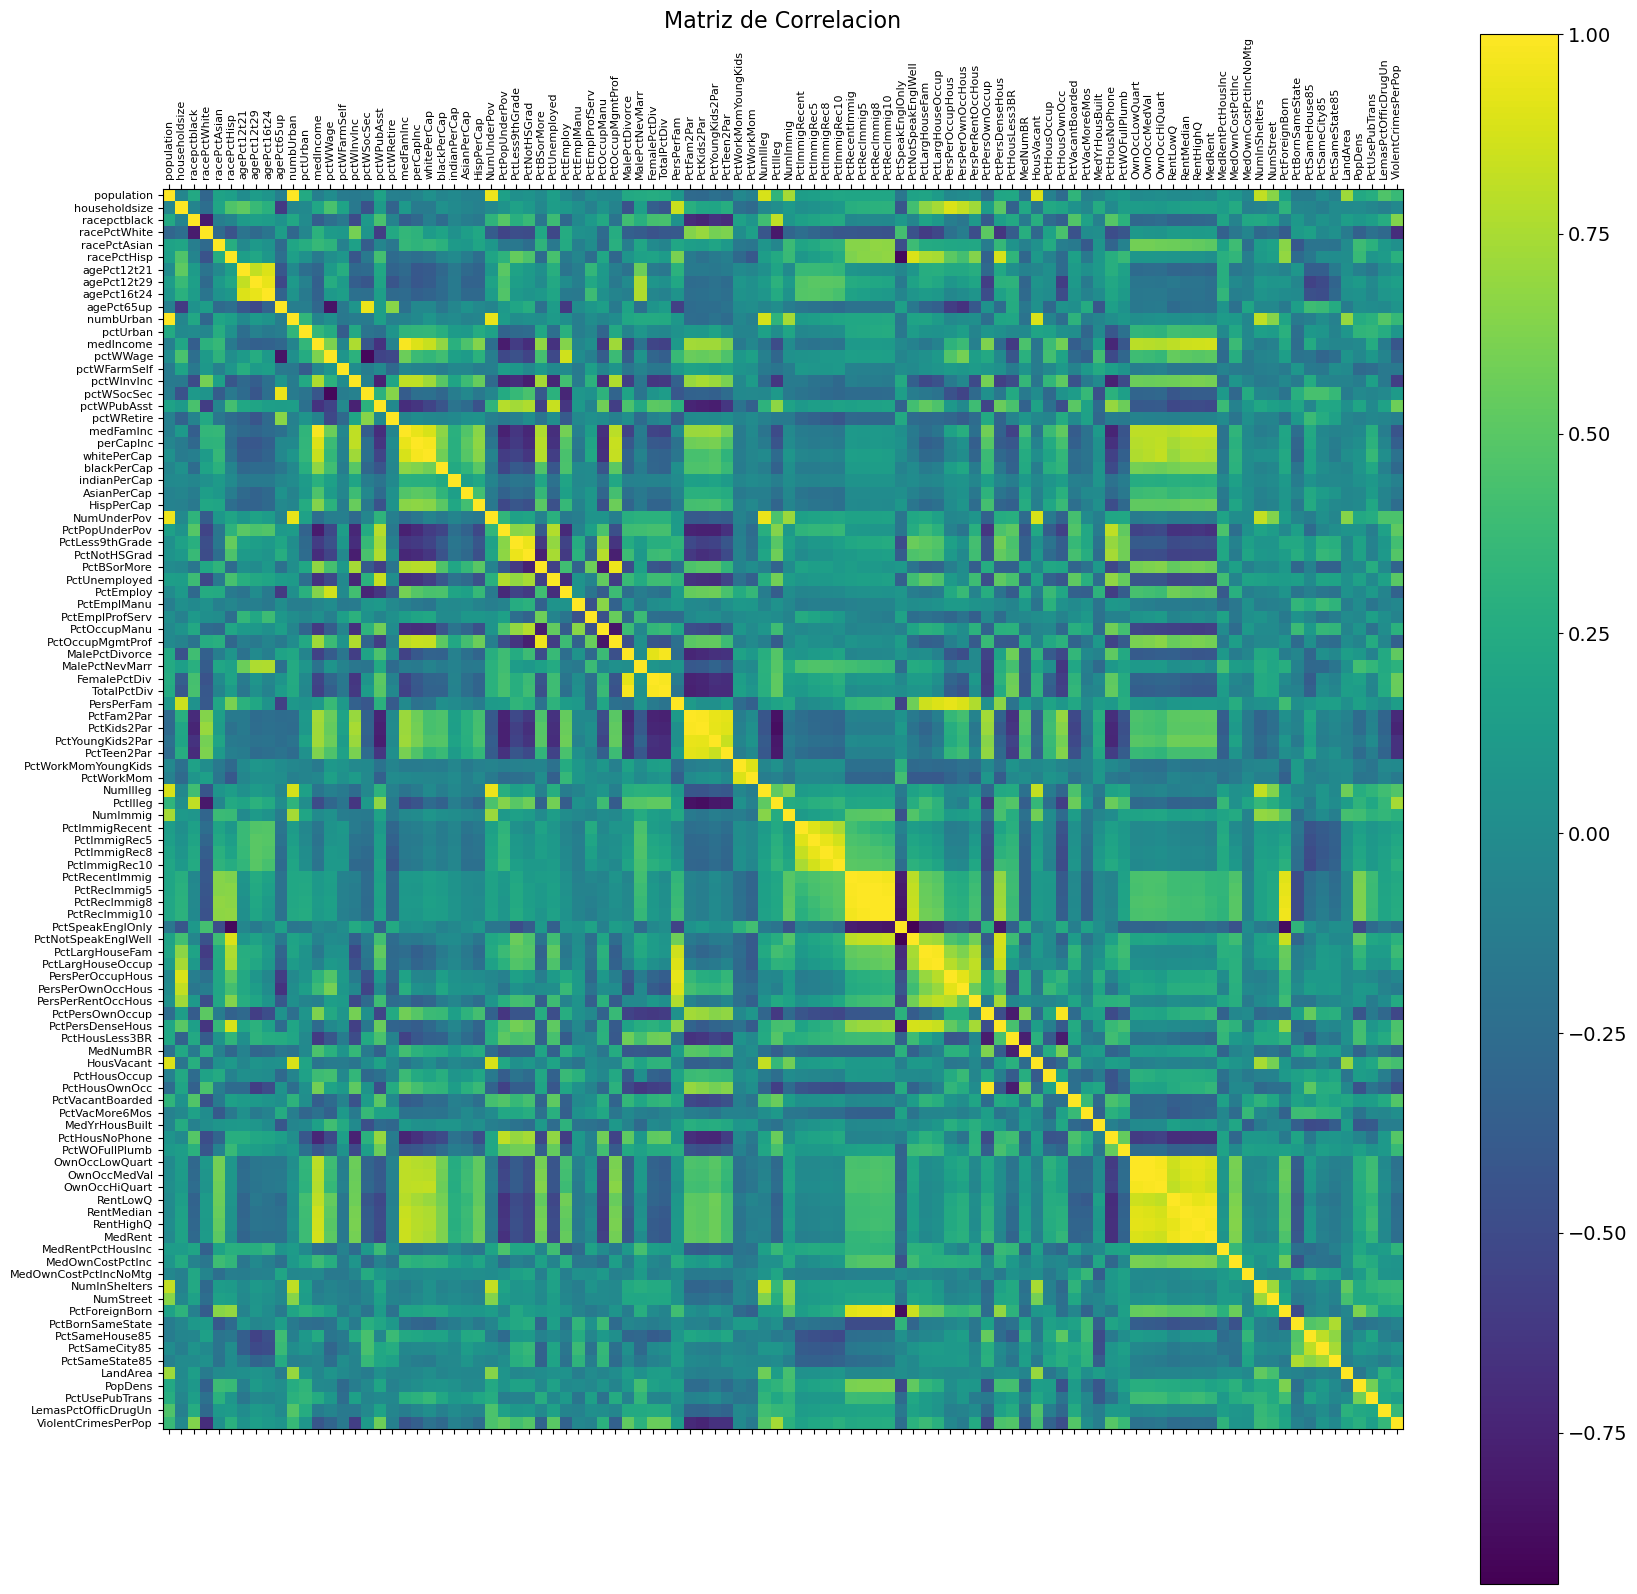

In [389]:
f = plt.figure(figsize=(20, 20))
plt.matshow(base.corr(), fignum=f.number)
plt.xticks(range(base.select_dtypes(['number']).shape[1]), base.select_dtypes(['number']).columns, fontsize=8, rotation=90)
plt.yticks(range(base.select_dtypes(['number']).shape[1]), base.select_dtypes(['number']).columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Matriz de Correlacion', fontsize=16);

### Variable que tiene la más alta correlación con la variable objetivo

In [22]:
corr_matrix = base.corr(method='pearson')
corr_matrix = pd.DataFrame(corr_matrix['ViolentCrimesPerPop'])

In [23]:
def topCorr(corr_mat):
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['var_1','vare_2','r']
    corr_mat = corr_mat.loc[corr_mat['var_1'] != corr_mat['vare_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

In [24]:
# variable con mayor correlacion con la variables objetivo
# La correlacion es negativa
base_aux = topCorr(corr_matrix)
base_aux.head(1)

,var_1,vare_2,r,abs_r
43,PctKids2Par,ViolentCrimesPerPop,-0.738424,0.738424


### Top 10 variables más correlacionadas con la variable objetivo

In [25]:
# 10 variables con myor correlacion la variable objetivo
base_aux = topCorr(corr_matrix)
base_aux.head(10)

,var_1,vare_2,r,abs_r
43,PctKids2Par,ViolentCrimesPerPop,-0.738424,0.738424
49,PctIlleg,ViolentCrimesPerPop,0.737957,0.737957
42,PctFam2Par,ViolentCrimesPerPop,-0.706667,0.706667
3,racePctWhite,ViolentCrimesPerPop,-0.684770,0.684770
44,PctYoungKids2Par,ViolentCrimesPerPop,-0.666059,0.666059
45,PctTeen2Par,ViolentCrimesPerPop,-0.661582,0.661582
2,racepctblack,ViolentCrimesPerPop,0.631264,0.631264
15,pctWInvInc,ViolentCrimesPerPop,-0.576324,0.576324
17,pctWPubAsst,ViolentCrimesPerPop,0.574665,0.574665
39,FemalePctDiv,ViolentCrimesPerPop,0.556032,0.556032


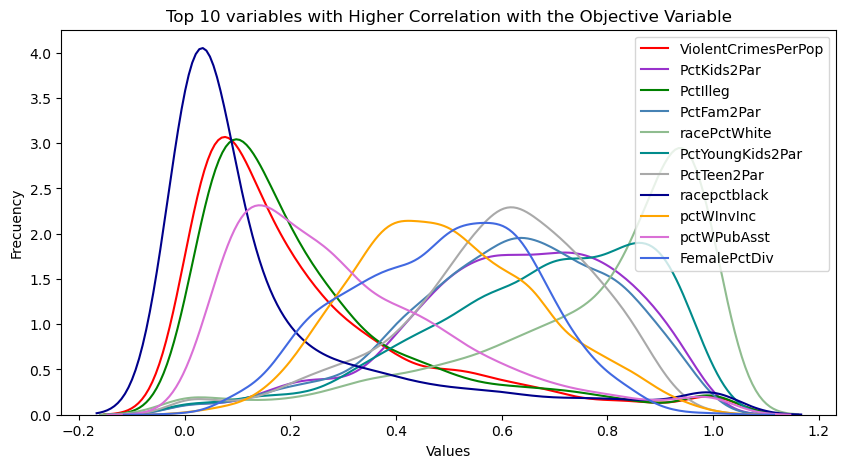

In [828]:
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(base['ViolentCrimesPerPop'], hist=False, color="red")
ax2 = sns.distplot(base['PctKids2Par'], hist=False, color="darkorchid" , ax=ax1)
ax3 = sns.distplot(base['PctIlleg'], hist=False, color="green" , ax=ax1)
ax4 = sns.distplot(base['PctFam2Par'], hist=False, color="steelblue" , ax=ax1)
ax5 = sns.distplot(base['racePctWhite'], hist=False, color="darkseagreen" , ax=ax1)
ax6 = sns.distplot(base['PctYoungKids2Par'], hist=False, color="darkcyan" , ax=ax1)
ax7 = sns.distplot(base['PctTeen2Par'], hist=False, color="darkgrey" , ax=ax1)
ax8 = sns.distplot(base['racepctblack'], hist=False, color="darkblue" , ax=ax1)
ax9 = sns.distplot(base['pctWInvInc'], hist=False, color="orange" , ax=ax1)
ax10 = sns.distplot(base['pctWPubAsst'], hist=False, color="orchid" , ax=ax1)
ax11 = sns.distplot(base['FemalePctDiv'], hist=False, color="royalblue" , ax=ax1)

plt.legend(labels=['ViolentCrimesPerPop', 'PctKids2Par', 'PctIlleg', 'PctFam2Par', 'racePctWhite',
                  'PctYoungKids2Par', 'PctTeen2Par', 'racepctblack', 'pctWInvInc', 'pctWPubAsst', 'FemalePctDiv'])
plt.title('Top 10 variables with Higher Correlation with the Objective Variable')
plt.xlabel('Values')
plt.ylabel('Frecuency')
plt.show()

## Preparación de la base minable y Estandarizacion
Para la seleccion de variables y el desarrollo del modelo se utilzaran algoritmos como RFECV, Lasso, Ridge, ElasticNet, el top de variables mas correlacionadas. Dado que los métodos de regularización actúan sobre la magnitud de los coeficientes del modelo, todos deben de estár en la misma escala y con una distribucion normal, por lo que es necesario estandarizar los predictores antes de entrenar el modelo.

### Normalizacion
Referente a la normalizacion, se puede observar que las variables vienen desde su origen re escalados entre 0 y 1, posteriormente de estandarizacion restando la media y diviendolo entre la desviacion estandar para que funcionen mejor en metodos de regularizacion. Los datos no fueron normalizados con respecto a la norma de un vector.

In [26]:
base_X = base.drop(['ViolentCrimesPerPop'], axis=1) # independientes
base_y = base[['ViolentCrimesPerPop']] # dependientes

In [27]:
scaler = StandardScaler()

In [28]:
base_X = pd.DataFrame(scaler.fit_transform(base_X), columns = base_X.columns)

In [29]:
base_X.shape

(1994, 99)

In [30]:
base_y.shape

(1994, 1)

#### Reduccion de Variables utilizando RFECV

In [31]:
# Utilizamos Recursive feature elimination with cross-validation para seleccionar las mejores variables
# se utiliza la regresion lineal en RFECV
estimador_selector = LinearRegression()
selector_rfecv = RFECV(estimador_selector)
base_X_rfecv = selector_rfecv.fit_transform(base_X, base_y)

# RFECV selecciona 42 variables como las de mayor peso para el modelo
evaluacion_rfecv = sorted(
    filter(lambda c: c[2], 
        zip(
            base_X.columns,
            selector_rfecv.ranking_,
            selector_rfecv.get_support()
        )
    ), key=lambda c: c[1],reverse=True
)

evaluacion_rfecv

[('population', 1, True),
 ('racepctblack', 1, True),
 ('racePctHisp', 1, True),
 ('agePct12t29', 1, True),
 ('numbUrban', 1, True),
 ('pctUrban', 1, True),
 ('medIncome', 1, True),
 ('pctWWage', 1, True),
 ('pctWInvInc', 1, True),
 ('pctWRetire', 1, True),
 ('medFamInc', 1, True),
 ('perCapInc', 1, True),
 ('whitePerCap', 1, True),
 ('PctPopUnderPov', 1, True),
 ('PctEmploy', 1, True),
 ('PctOccupMgmtProf', 1, True),
 ('MalePctDivorce', 1, True),
 ('MalePctNevMarr', 1, True),
 ('FemalePctDiv', 1, True),
 ('TotalPctDiv', 1, True),
 ('PctKids2Par', 1, True),
 ('PctWorkMom', 1, True),
 ('PctIlleg', 1, True),
 ('PctRecImmig5', 1, True),
 ('PctRecImmig8', 1, True),
 ('PctRecImmig10', 1, True),
 ('PctNotSpeakEnglWell', 1, True),
 ('PctLargHouseOccup', 1, True),
 ('PersPerOccupHous', 1, True),
 ('PersPerRentOccHous', 1, True),
 ('PctPersOwnOccup', 1, True),
 ('PctPersDenseHous', 1, True),
 ('HousVacant', 1, True),
 ('PctHousOwnOcc', 1, True),
 ('OwnOccLowQuart', 1, True),
 ('OwnOccMedVal', 1

In [32]:
base_X_rfecv.shape

(1994, 42)

#### Reduccion de Variables tomando las 10 variables mas correlacionadas con la variable objetivo

In [33]:
base_aux.head(10)

,var_1,vare_2,r,abs_r
43,PctKids2Par,ViolentCrimesPerPop,-0.738424,0.738424
49,PctIlleg,ViolentCrimesPerPop,0.737957,0.737957
42,PctFam2Par,ViolentCrimesPerPop,-0.706667,0.706667
3,racePctWhite,ViolentCrimesPerPop,-0.684770,0.684770
44,PctYoungKids2Par,ViolentCrimesPerPop,-0.666059,0.666059
45,PctTeen2Par,ViolentCrimesPerPop,-0.661582,0.661582
2,racepctblack,ViolentCrimesPerPop,0.631264,0.631264
15,pctWInvInc,ViolentCrimesPerPop,-0.576324,0.576324
17,pctWPubAsst,ViolentCrimesPerPop,0.574665,0.574665
39,FemalePctDiv,ViolentCrimesPerPop,0.556032,0.556032


In [34]:
base_aux_corr = pd.DataFrame(base_aux.head(10))
base_aux_corr = base_aux_corr['var_1'].tolist()
base_X_corr = base_X[base_aux_corr]

base_X_corr.shape

(1994, 10)

#### Reduccion de Variables con PCA tomando 30 componentes

Suma de la varianza: 92.98
Suma del porcentaje de la varianza: 0.94


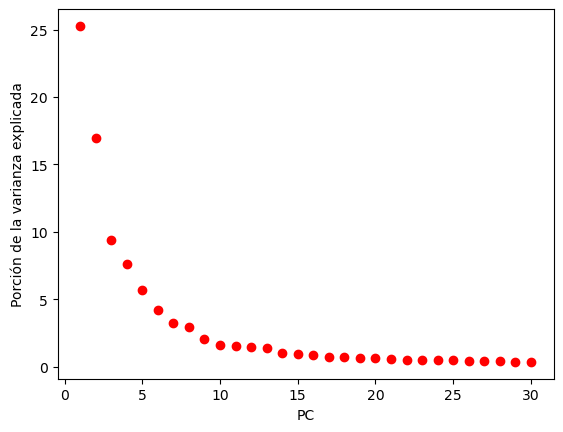

(1495, 99)


In [88]:
#Definimos un numero de componentes
c = 30
pca = PCA(n_components = c)
base_X_pca = pca.fit_transform(base_X)

#print("Porcion de la varianza: %s" % pca.explained_variance_)
print("Suma de la varianza: %s" % sum(pca.explained_variance_).round(2))

#print("Porcentaje de la varianza: %s" % pca.explained_variance_ratio_)
print("Suma del porcentaje de la varianza: %s" % sum(pca.explained_variance_ratio_).round(2))

%matplotlib inline
plt.figure()
plt.scatter(np.arange(1,(c+1)),pca.explained_variance_ratio_*100, c = 'r')
plt.xlabel('PC')
plt.ylabel('Porción de la varianza explicada')
plt.show()
print(X_train.shape)

In [89]:
base_X_pca.shape

(1994, 30)

## Pronostico de la Variable Objetivo

In [37]:
# Utilizamos RFECV, PCA, las 10 variables mas correlacionadas y todas las variables
# Para evaluar los modelos utilizamos rmse con cross validation

In [171]:
def rmse(y_real, y_pred):
    return np.sqrt(mean_squared_error(y_real, y_pred))

def rmse_cv(estimator, X, y):
    y_pred = estimator.predict(X)
    return rmse(y, y_pred)

def evaluar_modelo(estimador, X, y):
    resultados_estimador = cross_validate(estimador, X, y,
                     scoring=rmse_cv, n_jobs=-1, cv=10, return_train_score=True)
    return resultados_estimador

In [172]:
resultados = {}

def ver_resultados():
    resultados_df  = pd.DataFrame(resultados).T
    resultados_cols = resultados_df.columns
    for col in resultados_df:
        resultados_df[col] = resultados_df[col].apply(np.mean)
        resultados_df[col+"_idx"] = resultados_df[col] / resultados_df[col].min()
    return resultados_df

#res = cross_validate(LinearRegression(), base_X, base_y,
#                     scoring=rmse_cv, n_jobs=-1, cv=10)
#np.mean(res['test_score'])

In [94]:
resultados["LR_All"] = evaluar_modelo(LinearRegression(), base_X, base_y)
resultados["LR_CORR"] = evaluar_modelo(LinearRegression(), base_X_corr, base_y)
resultados["LR_RFECV"] = evaluar_modelo(LinearRegression(), base_X_rfecv, base_y)
resultados["LR_PCA"] = evaluar_modelo(LinearRegression(), base_X_pca, base_y)

In [95]:
# Si bien el mejor resultado en el entrenamiento nos da utilizando todas las variables
# Usando RFECV se obtiene un mejor resultado en el test (Menor error RMSE)
# La diferencia entre el error RMSE test y el train es mucho menor en RFECV
# El sobreajuste es ligeramente superior a RFECV cuando se usan todas las variables 
# El tiempo de entrenamiento es mayor utilizando todas las variables

# Por lo que se escogera para el desarrollo del modelo las 42 variables recomendadas por RFECV
# Y tambien todas las variables para compararlo con las variables de RFECV

ver_resultados()

,fit_time,score_time,test_score,train_score,fit_time_idx,score_time_idx,test_score_idx,train_score_idx
LR_All,0.012759,0.002412,0.136024,0.128503,5.605942,2.669164,1.016228,1.000000
LR_CORR,0.002602,0.001151,0.144627,0.144085,1.143351,1.273581,1.080498,1.121257
LR_RFECV,0.003783,0.001231,0.133852,0.131004,1.662187,1.362550,1.000000,1.019463
LR_PCA,0.002276,0.000904,0.138527,0.136602,1.000000,1.000000,1.034927,1.063028


### Seleccion de los mejores predictores segun RFECV para el desarrollo del modelo

In [42]:
rfecv_aux = pd.DataFrame(evaluacion_rfecv)
rfecv_var = rfecv_aux[0].tolist()

In [43]:
base_X.shape

(1994, 99)

In [44]:
new_base_X = base_X[rfecv_var]

In [45]:
new_base_X.shape

(1994, 42)

### Desarrollo del modelo

In [173]:
# Entrenamiento y Test
X_train_rfecv, X_test_rfecv, y_train_rfecv, y_test_rfecv = train_test_split(new_base_X, base_y, 
                                                                            random_state=212, shuffle=True)

In [174]:
# grafico de distribucion de 3 variables
def GrafDist_3(Roja, Azul, Verde, RojoNom, AzulNom, VerdeNom, Titulo):
    plt.figure(figsize=(10, 5))

    ax1 = sns.distplot(Roja, hist=False, color="r", label=RojoNom)
    ax2 = sns.distplot(Azul, hist=False, color="b", label=AzulNom, ax=ax1)
    ax3 = sns.distplot(Verde, hist=False, color="g", label=VerdeNom, ax=ax1)

    plt.title(Titulo)
    plt.xlabel('ViolentCrimesPerPop')
    plt.ylabel('Frecuency')
    plt.legend(labels=['Real', 'Train', 'Test'])

    plt.show()

In [175]:
# grafico de distribucion de 2 variables
def GrafDist_2(Roja, Azul, RojoNom, AzulNom, Titulo):
    plt.figure(figsize=(10, 5))

    ax1 = sns.distplot(Roja, hist=False, color="r", label=RojoNom)
    ax2 = sns.distplot(Azul, hist=False, color="b", label=AzulNom, ax=ax1)

    plt.title(Titulo)
    plt.xlabel('ViolentCrimesPerPop')
    plt.ylabel('Frecuency')
    plt.legend(labels=['Real', 'Test'])

    plt.show()

#### Resultados con variables RFECV

In [176]:
# Generando el modelo de Regresion Lineal
mlMulE = LinearRegression()

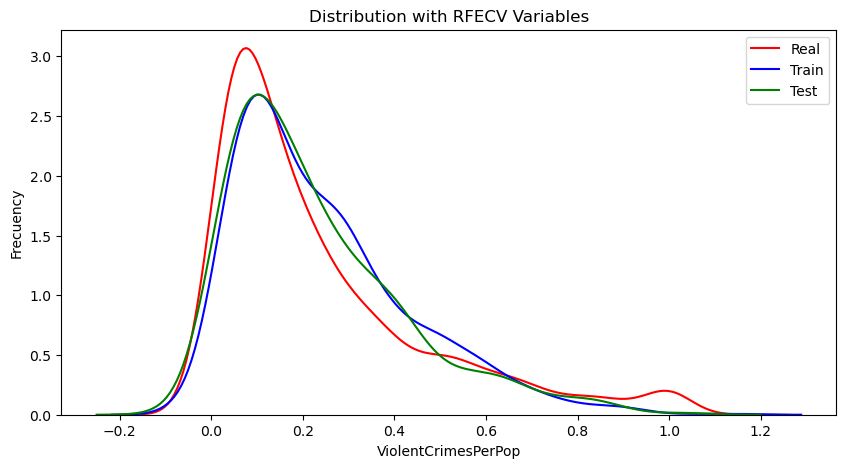

Entrenamiento con variables RFECV: El R_cuadrado es:0.643982   y el RMSE es:0.139563
Test con variables RFECV: El R_cuadrado es:0.728669   y el RMSE es:0.116421


In [177]:
X = X_train_rfecv
y = y_train_rfecv
mlMulE.fit(X,y)
ypredMulE = mlMulE.predict(X)
rq_train_rfecv = np.mean(cross_val_score(mlMulE, X, y, cv=10)) #mlMulE.score(X,y)
res = cross_validate(LinearRegression(), X, y,
                     scoring=rmse_cv, n_jobs=-1, cv=10)
rmse_train_rfecv = np.mean(res['test_score']) #np.sqrt(mean_squared_error(y, ypredMulE))

X = X_test_rfecv
y = y_test_rfecv
ypredMulC = mlMulE.predict(X)
rq_test_rfecv = mlMulE.score(X,y)
rmse_test_rfecv = np.sqrt(mean_squared_error(y, ypredMulC))

Titulo = 'Distribution with RFECV Variables'
GrafDist_3(base_y, ypredMulE, ypredMulC, "Real", "Train", "Test", Titulo)

print('Entrenamiento con variables RFECV: El R_cuadrado es:{:.6f}   y el RMSE es:{:.6f}'.format(rq_train_rfecv, rmse_train_rfecv))
print('Test con variables RFECV: El R_cuadrado es:{:.6f}   y el RMSE es:{:.6f}'.format(rq_test_rfecv, rmse_test_rfecv))

#### Resultados con todas las variables

In [128]:
# Entrenamiento y Test
X_train, X_test, y_train, y_test = train_test_split(base_X, base_y, random_state=212, shuffle=True)

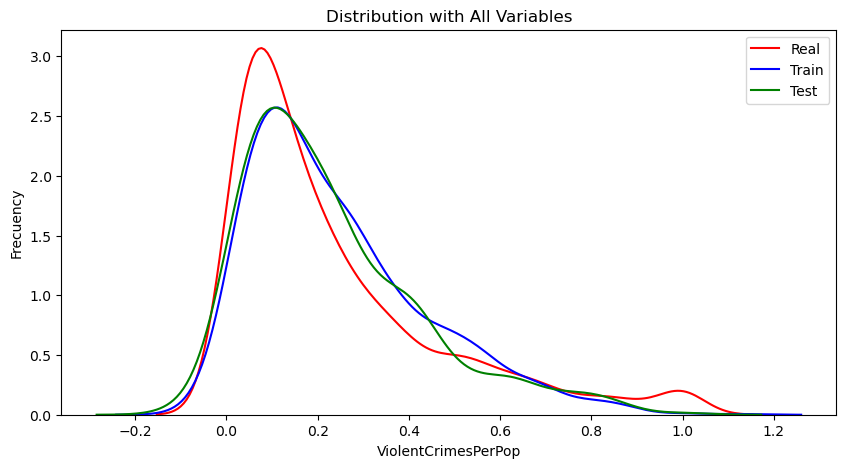

Entrenamiento con todas las variables: El R_cuadrado es:0.635215   y el RMSE es:0.141308
Test con todas las variables: El R_cuadrado es:0.704790   y el RMSE es:0.121436


In [129]:
X = X_train
y = y_train
mlMulE.fit(X,y)
ypredMulE = mlMulE.predict(X)
rq_train_all = np.mean(cross_val_score(mlMulE, X, y, cv=10)) #mlMulE.score(X,y)
res = cross_validate(LinearRegression(), X, y,
                     scoring=rmse_cv, n_jobs=-1, cv=10)
rmse_train_all = np.mean(res['test_score']) #np.sqrt(mean_squared_error(y, ypredMulE))

X = X_test
y = y_test
ypredMulC = mlMulE.predict(X)
rq_test_all = mlMulE.score(X,y)
rmse_test_all = np.sqrt(mean_squared_error(y, ypredMulC))

Titulo = 'Distribution with All Variables'
GrafDist_3(base_y, ypredMulE, ypredMulC, "Real", "Train", "Test", Titulo)

print('Entrenamiento con todas las variables: El R_cuadrado es:{:.6f}   y el RMSE es:{:.6f}'.format(rq_train_all, rmse_train_all))
print('Test con todas las variables: El R_cuadrado es:{:.6f}   y el RMSE es:{:.6f}'.format(rq_test_all, rmse_test_all))

Aprovechando que se tiene la data procesada, se aplicara tambien regularizacion Lasso, Ridge y Elastic net para ver los resultados e intentar a mejorar el modelo

#### Resultados con Ridge

In [135]:
modelo = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
         )

_ = modelo.fit(X = X_train, y = y_train)

print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 0.015885651294280528


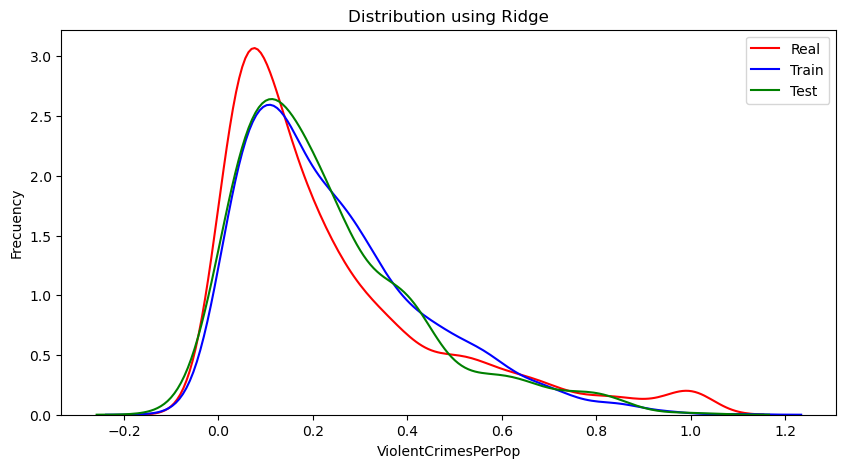

Entrenamiento con Ridge: El R_cuadrado es:0.635215   y el RMSE es:0.141308
Test con Ridge: El R_cuadrado es:0.715303   y el RMSE es:0.119254


In [137]:
X = X_train
y = y_train
ypredMulE = modelo.predict(X)

rq_train_ridge = np.mean(cross_val_score(mlMulE, X, y, cv=10)) #mlMulE.score(X,y)
res = cross_validate(LinearRegression(), X, y,
                     scoring=rmse_cv, n_jobs=-1, cv=10)
rmse_train_ridge = np.mean(res['test_score']) #np.sqrt(mean_squared_error(y, ypredMulE))

X = X_test
y = y_test
ypredMulC = modelo.predict(X)
rq_test_ridge = modelo.score(X,y)
rmse_test_ridge = np.sqrt(mean_squared_error(y, ypredMulC))

Titulo = 'Distribution using Ridge'
GrafDist_3(base_y, ypredMulE, ypredMulC, "Real", "Train", "Test", Titulo)

print('Entrenamiento con Ridge: El R_cuadrado es:{:.6f}   y el RMSE es:{:.6f}'.format(rq_train_ridge, rmse_train_ridge))
print('Test con Ridge: El R_cuadrado es:{:.6f}   y el RMSE es:{:.6f}'.format(rq_test_ridge, rmse_test_ridge))

#### Resultados con Lasso

In [155]:
modelo = LassoCV(
            alphas          = np.logspace(-10, 50, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

# dimensiones (n_alphas, n_folds)
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_1sd}")

Mejor valor de alpha encontrado: 6.669919663030115e-06
Mejor valor de alpha encontrado + 1 desviación estándar: [0.00344896]


In [160]:
modelo = Lasso(alpha=optimo_1sd, normalize=True)
modelo.fit(X_train, y_train)

Lasso(alpha=array([0.00344896]), normalize=True)

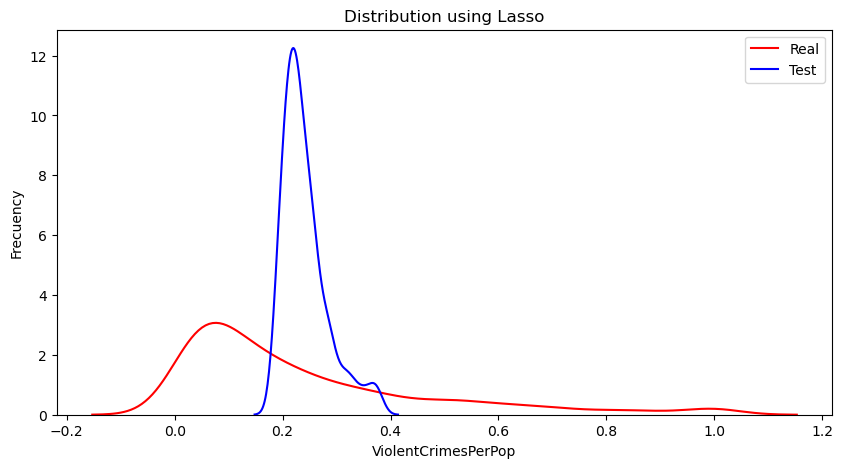

Test con Lasso: El R_cuadrado es:0.252008   y el RMSE es:0.193299


In [161]:
X = X_test
y = y_test
ypredMulC = modelo.predict(X)
rq_test_lasso = modelo.score(X,y)
rmse_test_lasso = np.sqrt(mean_squared_error(y, ypredMulC))

Titulo = 'Distribution using Lasso'
GrafDist_2(base_y, ypredMulC, "Real", "Test", Titulo)

print('Test con Lasso: El R_cuadrado es:{:.6f}   y el RMSE es:{:.6f}'.format(rq_test_lasso, rmse_test_lasso))

#### Resultados con Elasticnet

In [166]:
modelo = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

Mejor valor de alpha encontrado: 7.934096665797492e-06
Mejor valor de l1_ratio encontrado: 0.0


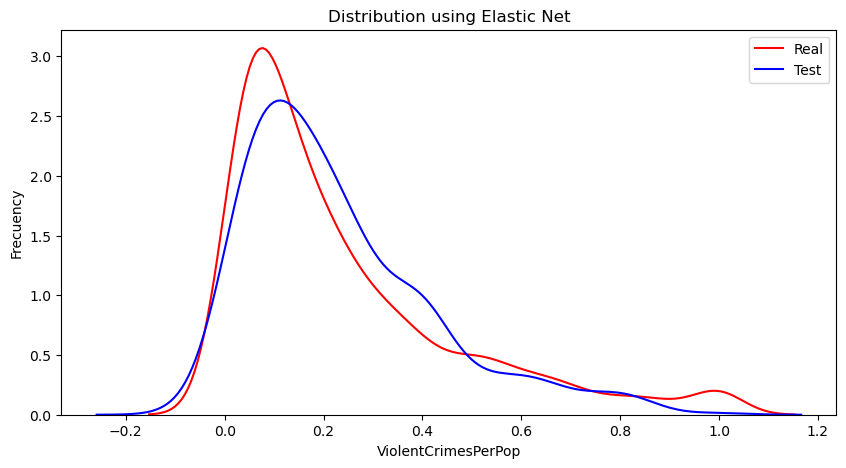

Test con todas las Variables: El R_cuadrado es:0.713978   y el RMSE es:0.119531


In [167]:
X = X_test
y = y_test
ypredMulC = modelo.predict(X)
rq_test_elastic = modelo.score(X,y)
rmse_test_elastic = np.sqrt(mean_squared_error(y, ypredMulC))

Titulo = 'Distribution using Elastic Net'
GrafDist_2(base_y, ypredMulC, "Real", "Test", Titulo)

print('Test con todas las Variables: El R_cuadrado es:{:.6f}   y el RMSE es:{:.6f}'.format(rq_test_elastic, rmse_test_elastic))

## Conclusiones

In [168]:
df_comparacion = pd.DataFrame({
                    'Modelo': ['All Var', 'RFECV', 'Ridge', 'Lasso', 'Elastic-net'],
                    'RMSE': [rmse_test_all, rmse_test_rfecv, rmse_test_ridge, rmse_test_lasso,  rmse_test_elastic],
                    'R2': [rq_test_all, rq_test_rfecv, rq_test_ridge, rq_test_lasso,  rq_test_elastic]
                 })

df_comparacion

,Modelo,RMSE,R2
0,All Var,0.121436,0.704790
1,RFECV,0.116421,0.728669
2,Ridge,0.119254,0.715303
3,Lasso,0.193299,0.252008
4,Elastic-net,0.119531,0.713978


- Se puede concluir el mejor modelo se genera con las 42 variables que <b>RFECV</b> considera como mejores predictores de la variable dependiente 'ViolentCrimesPerPop', ya que esta tiene el menor error RMSE (0.116421) y el mayor R2 (72.86 %)
- La segunda mejor opcion es utilizando regularizacion Ridge con un RMSE de 0.119254 y un R2 de 71.53%.

In [178]:
# 42 mejores predictores para el modelo de regresion lineal
rfecv_var

['population',
 'racepctblack',
 'racePctHisp',
 'agePct12t29',
 'numbUrban',
 'pctUrban',
 'medIncome',
 'pctWWage',
 'pctWInvInc',
 'pctWRetire',
 'medFamInc',
 'perCapInc',
 'whitePerCap',
 'PctPopUnderPov',
 'PctEmploy',
 'PctOccupMgmtProf',
 'MalePctDivorce',
 'MalePctNevMarr',
 'FemalePctDiv',
 'TotalPctDiv',
 'PctKids2Par',
 'PctWorkMom',
 'PctIlleg',
 'PctRecImmig5',
 'PctRecImmig8',
 'PctRecImmig10',
 'PctNotSpeakEnglWell',
 'PctLargHouseOccup',
 'PersPerOccupHous',
 'PersPerRentOccHous',
 'PctPersOwnOccup',
 'PctPersDenseHous',
 'HousVacant',
 'PctHousOwnOcc',
 'OwnOccLowQuart',
 'OwnOccMedVal',
 'RentLowQ',
 'RentHighQ',
 'MedRent',
 'MedOwnCostPctIncNoMtg',
 'NumStreet',
 'PctForeignBorn']

In [179]:
# Coeficientes de los 42 mejores predictores para el modelo de regresion lineal
mlMulE.coef_

array([[ 0.0271017 ,  0.05521991,  0.01692937, -0.03671616, -0.04781099,
         0.01916082, -0.08901885, -0.0539692 , -0.03410516, -0.01718703,
         0.08448854,  0.01164818, -0.04380502, -0.04404897,  0.03390227,
         0.02476325,  0.08632726,  0.03687468,  0.01994299, -0.10000671,
        -0.08896893, -0.02041014,  0.0210624 , -0.01655951,  0.04076535,
        -0.02560832, -0.0294983 , -0.02851597,  0.08127439, -0.05120494,
        -0.1580558 ,  0.04900783,  0.03685649,  0.13465159, -0.09295568,
         0.08286607, -0.03614839, -0.0339162 ,  0.0818707 , -0.0200217 ,
         0.01706337,  0.01584819]])

In [184]:
# Resultados en el Test
pronostico = mlMulE.predict(X = X_test_rfecv)
pronostico = pd.DataFrame(pronostico)
real = y_test_rfecv.reset_index(drop=True)
df_final = pd.concat([real, pronostico], axis=1)
df_final = df_final.rename(columns={"ViolentCrimesPerPop": "Real", 0: "Pronostico"})

df_final.head()

,Real,Pronostico
0,0.65,0.443007
1,0.02,0.052416
2,0.07,0.138060
3,0.90,0.901821
4,0.15,0.061235


## Recomendaciones

- Ajustar los hiperparametros de regularizacion de Ridge, Lasso y ElasticNet
- Verificar multicolinealidad entre variables
- Revisar por que la variable state al volverse en dummie se vuelve la variable ideal por defecto para el pronostico de la variable objetivo segun RFECV(Error al momento de ejecutar o sesfo por parte de RFECV)
- Optimizar el uso de PCA con una mejor seleccion de variables